In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1{
    text-align: center;
    background-color: blue;
    padding: 20px;
    margin: 0;
    color: white;
    font-family: ariel;
    border-radius: 80px
}

h2,h3{
    text-align: center;
    border-style: solid;
    border-width: 3px;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: gold;
}

body, p {
    font-family: ariel;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: ariel;
    color: purple;
}
</style>
""")

In [3]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#8F003C','#eb3446','Tourney','Smokum',45,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+""";</style>
    <h4 class='font-effect-3d-float' style='font-family:"""+\
    font+"""; color:"""+fontcolor+"""; font-size:"""+\
    str(fontsize)+"""px;'>%s</h4>"""%string))
    
    
dhtml('💥 Movie Recommendation System 💥' )

In [4]:
import numpy as np
import pandas as pd

In [5]:
# read dataset from csv files
movies = pd.read_csv('movies.csv',encoding='utf-8')
ratings = pd.read_csv('ratings.csv')

In [6]:
# count the number of people who have scored for each movie
valid_movie=pd.DataFrame(ratings.groupby('movieId')['userId'].count())
valid_movie.reset_index(inplace=True)
valid_movie.head()

,movieId,userId
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [7]:
# filter out the movie whose scoring number by people is less than 10 as invalid movie
invalid_movieId=valid_movie[valid_movie['userId']<10].index
invalid_movieId.tolist()
ratings.drop(index=invalid_movieId, inplace=True)

In [8]:
ratings = ratings.reset_index(drop=True)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,50,5.0,964982931
4,1,70,3.0,964982400


In [9]:
# filter out the user who scored movies less than 50 as invalid user
valid_user=pd.DataFrame(ratings.groupby('userId')['movieId'].count())
valid_user.reset_index(inplace=True)
valid_user.head()
invalid_userId=valid_user[valid_user['movieId']<50].index
invalid_userId.tolist()
ratings.drop(index=invalid_userId, inplace=True)

In [10]:
ratings = ratings.reset_index(drop=True)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,50,5.0,964982931
2,1,101,5.0,964980868
3,1,151,5.0,964984041
4,1,216,5.0,964981208


In [11]:
ratings2=pd.merge(movies,ratings,on='movieId')
ratings2.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,18,3.5,1455209816
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,4.0,965705637
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,43,5.0,848993983


In [12]:
ratings2.drop(columns=['genres','timestamp'],inplace=True)
ratings2['title']=ratings2['title'].str.replace(",","_")
ratings2.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),15,2.5
2,1,Toy Story (1995),18,3.5
3,1,Toy Story (1995),19,4.0
4,1,Toy Story (1995),43,5.0


In [13]:
# write the dataset into a csv file
ratings2.to_csv('project3.csv',index=False)

In [2]:
# coding = utf-8
# Item-based filtering algorithm
import random
import pandas as pd
import math
from operator import itemgetter
movies = pd.read_csv("movies.csv")

class ItemBasedCF():
    # Initiate the parameters
    def __init__(self,K):
        # Find the most K similar movies and recommend 10 for the selected user 
        self.n_sim_movie = K
        self.n_rec_movie = 10
 
        # divide the dataset into training dataset and test dataset
        self.trainSet = {}
        self.testSet = {}
 
        # movie_sim_matrix
        self.movie_sim_matrix = {}
        self.movie_popular = {}
        self.movie_count = 0
 
        print('Top similar movie number = %d' % self.n_sim_movie)
        print('Recommneded movie number = %d' % self.n_rec_movie)
 
 
    # get dataset from csv file
    def get_dataset(self, filename, pivot=0.7):
        # set the proportion of training dataset and test dataset: 7:3
        trainSet_len = 0
        testSet_len = 0
        for line in self.load_file(filename):
            movie, title, user, rating = line.split(',')
            if(random.random() < pivot):# 70% probability for training dataset and 30% for test dataset
                self.trainSet.setdefault(user, {})  
                #trainSet form：{'1': {'1287': '2.0', '1953': '4.0', '2105': '4.0'}, '2': {'10': '4.0', '62': '3.0'}}
                self.trainSet[user][movie] = rating
                trainSet_len += 1
            else:
                self.testSet.setdefault(user, {})
                self.testSet[user][movie] = rating
                testSet_len += 1
        print('*************Split trainingSet and testSet successfully!*************')
        print('TrainSet = %s' % trainSet_len)
        print('TestSet = %s' % testSet_len)
 
    # load file
    def load_file(self, filename):
        with open(filename, 'rb') as f:
            for i, line in enumerate(f):
                if i == 0:  # delete the title of the file
                    continue
                yield line.decode().strip('\r\n')
        print('*************Load %s successfully!*************' % filename)
 
 
    # calculate the similarity between movies
    def calc_movie_sim(self):
        for user, movies in self.trainSet.items():  #get every user and his watched movies in trainSet
            for movie in movies:
                if movie not in self.movie_popular:
                    self.movie_popular[movie] = 0
                self.movie_popular[movie] += 1  #calculate the times of movies watched by every user
 
        self.movie_count = len(self.movie_popular)  #the total number of movies
        print("Total movie number = %d" % self.movie_count)
 
        for user, movies in self.trainSet.items():  
            for m1 in movies:
                for m2 in movies:
                    if m1 == m2:
                        continue
                    self.movie_sim_matrix.setdefault(m1, {})
                    self.movie_sim_matrix[m1].setdefault(m2, 0)
                    # self.movie_sim_matrix[m1][m2] += 1:the number of user+1 who liked m1 and m2 at the same time
                    self.movie_sim_matrix[m1][m2] += 1 /math.log(1 + len(movies)) #ItemCF-IUF improvement，penalizing active users
        print("*************Build co-rated users matrix successfully!*************")
        print("*************Calculating movie similarity matrix ...")
        for m1, related_movies in self.movie_sim_matrix.items():    
            for m2, count in related_movies.items():   
                # Pay attention to the processing of 0 vectors, that is, the number of users of a certain movie is 0
                if self.movie_popular[m1] == 0 or self.movie_popular[m2] == 0:
                    self.movie_sim_matrix[m1][m2] = 0
                else:
                    #Calculate the similarity between movies m1 and m2
                    self.movie_sim_matrix[m1][m2] = count / math.sqrt(self.movie_popular[m1] * self.movie_popular[m2])
        print('*************Calculate movie similarity matrix successfully!*************')
 
        #add normalization
        maxDict = {}
        max = 0
        for m1, related_movies in self.movie_sim_matrix.items():
            for m2, _ in related_movies.items():
                if self.movie_sim_matrix[m1][m2] > max:
                    max = self.movie_sim_matrix[m1][m2]
 
        for m1, related_movies in self.movie_sim_matrix.items():    #normalization
            for m2, _ in related_movies.items():
                # self.movie_sim_matrix[m1][m2] = self.movie_sim_matrix[m1][m2] / maxDict[m2]
                self.movie_sim_matrix[m1][m2] = self.movie_sim_matrix[m1][m2] / max
 
 
 
    # For the target user U, find top K similar movies and recommend N movies
    def recommend(self, user):
        K = self.n_sim_movie    
        N = self.n_rec_movie    
        rank = {}
        watched_movies = self.trainSet[user]    #Movies watched by this user
 
        for movie, rating in watched_movies.items():    #Iterate the movies the user has watched and evaluate them
            #Find the top K movie most similar to the movie, traverse the movie and the similarity with the movie
            for related_movie, w in sorted(self.movie_sim_matrix[movie].items(), key=itemgetter(1), reverse=True)[:K]:
                if related_movie in watched_movies: #If the user has already seen it, it is not recommended
                    continue
                rank.setdefault(related_movie, 0)
                rank[related_movie] += w * float(rating)    #Calculate the user's interest in the movie
                top_10 = sorted(rank.items(), key=itemgetter(1), reverse=True)[:N]
                top_10 = pd.DataFrame(top_10)
                top_10.columns = ['movieId','rank']
                top_10['movieId']=top_10['movieId'].astype(int)
                mix = pd.merge(top_10,movies,on='movieId')
                mix = mix.drop(columns=['genres'])
        return mix
    def recommend2(self, user):
        K = self.n_sim_movie    
        N = self.n_rec_movie    
        rank = {}
        watched_movies = self.trainSet[user]    
 
        for movie, rating in watched_movies.items():    
            for related_movie, w in sorted(self.movie_sim_matrix[movie].items(), key=itemgetter(1), reverse=True)[:K]:
                if related_movie in watched_movies: 
                    continue
                rank.setdefault(related_movie, 0)
                rank[related_movie] += w * float(rating)    
        return sorted(rank.items(),key=itemgetter(1),reverse=True)[:N]
 
 
    # Generate recommendations and evaluate by precision, recall, and coverage
    def evaluate(self):
        print('Evaluating start ...')
        N = self.n_rec_movie    #Number of movies to recommend
        hit = 0
        rec_count = 0
        test_count = 0
        all_rec_movies = set()
 
        for i, user in enumerate(self.trainSet):
            test_moives = self.testSet.get(user, {})    #Movies liked by users in the test set
            rec_movies = self.recommend2(user)   #Get recommended movies and calculated user interest in them
 
            for movie, w in rec_movies: #Iterate the movies recommended to the user
                if movie in test_moives:    #The movie is in the test set
                    hit += 1                #hit+1
                all_rec_movies.add(movie)
            rec_count += N
            test_count += len(test_moives)
 
        print(hit)
        print(rec_count)
        print(test_count)
        precision = hit / (1.0 * rec_count)
        recall = hit / (1.0 * test_count)
        coverage = len(all_rec_movies) / (1.0 * self.movie_count)
        print('precisioin=%.4f\trecall=%.4f\tcoverage=%.4f' % (precision, recall, coverage))
        return [precision, recall, coverage]
 
 
if __name__ == '__main__':
    rating_file = 'project3.csv'
    itemCF = ItemBasedCF(K)
    itemCF.get_dataset(rating_file)
    itemCF.calc_movie_sim()
    a = input()
    print(itemCF.recommend(a))
    #Explore the impact of the value K (the number of recommended movies is fixed at 10)
    #Evaluation indicators: changes in precision/recall/coverage
    #Experimental design: divide and test the data set 5 times for each K, and finally take the average value as the final result

Top similar movie number = 20
Recommneded movie number = 10
*************Load project3.csv successfully!*************
*************Split trainingSet and testSet successfully!*************
TrainSet = 65128
TestSet = 28004
Total movie number = 8415
*************Build co-rated users matrix successfully!*************
*************Calculating movie similarity matrix ...
*************Calculate movie similarity matrix successfully!*************
1
   movieId      rank                                              title
0     2571  5.312449                                 Matrix, The (1999)
1     1196  4.817795  Star Wars: Episode V - The Empire Strikes Back...
2     1210  4.780912  Star Wars: Episode VI - Return of the Jedi (1983)
3     1580  4.433762                   Men in Black (a.k.a. MIB) (1997)
4     1527  3.975522                          Fifth Element, The (1997)
5     3033  3.833225                                  Spaceballs (1987)
6     2012  3.470000                 Back to the Fut

*************Build co-rated users matrix successfully!*************
*************Calculating movie similarity matrix ...
*************Calculate movie similarity matrix successfully!*************
Evaluating start ...
1836
6080
27968
precisioin=0.3020	recall=0.0656	coverage=0.0745
Top similar movie number = 20
Recommneded movie number = 10
*************Load project3.csv successfully!*************
*************Split trainingSet and testSet successfully!*************
TrainSet = 65430
TestSet = 27702
Total movie number = 8421
*************Build co-rated users matrix successfully!*************
*************Calculating movie similarity matrix ...
*************Calculate movie similarity matrix successfully!*************
Evaluating start ...
1777
6080
27701
precisioin=0.2923	recall=0.0641	coverage=0.0735
Top similar movie number = 40
Recommneded movie number = 10
*************Load project3.csv successfully!*************
*************Split trainingSet and testSet successfully!*************
Train

*************Load project3.csv successfully!*************
*************Split trainingSet and testSet successfully!*************
TrainSet = 65353
TestSet = 27779
Total movie number = 8423
*************Build co-rated users matrix successfully!*************
*************Calculating movie similarity matrix ...
*************Calculate movie similarity matrix successfully!*************
Evaluating start ...
1730
6080
27778
precisioin=0.2845	recall=0.0623	coverage=0.0596
Top similar movie number = 320
Recommneded movie number = 10
*************Load project3.csv successfully!*************
*************Split trainingSet and testSet successfully!*************
TrainSet = 65200
TestSet = 27932
Total movie number = 8379
*************Build co-rated users matrix successfully!*************
*************Calculating movie similarity matrix ...
*************Calculate movie similarity matrix successfully!*************
Evaluating start ...
1709
6090
27932
precisioin=0.2806	recall=0.0612	coverage=0.0591
Top s

In [ ]:
Mat=[]
K_range=[5,10,20,40,80,160,320]
for K in K_range:
    M=[]
    for i in range(5):
        itemCF = ItemBasedCF(K)
        itemCF.get_dataset(rating_file) #Get and partition the dataset
        itemCF.calc_movie_sim() #Calculate movie similarity matrix
        m=itemCF.evaluate() 
        M.append(m) #Record the vector of metrics on each dataset
    Mat.append([sum([h[0] for h in M])/5,sum([h[1] for h in M])/5,sum([h[2] for h in M])/5])# calculate the average

,precision,recall,coverage
5,0.274010,0.059601,0.109454
10,0.292326,0.063617,0.092850
20,0.295127,0.064335,0.075453
40,0.302834,0.065763,0.068527
80,0.298383,0.064840,0.059342
160,0.291502,0.063591,0.057550
320,0.284569,0.061760,0.056826


Text(0.5, 1.0, 'Three evaluating indexes on different K values')

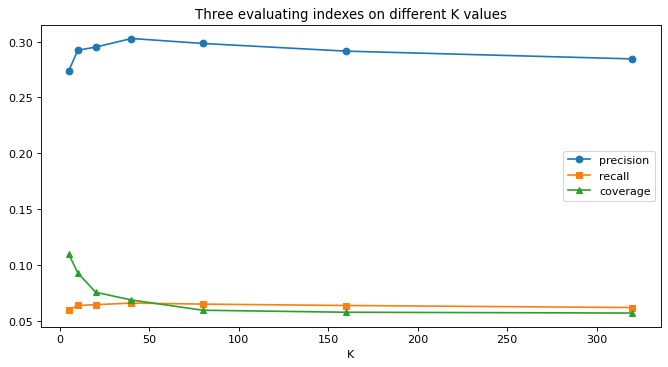

In [6]:
#performance curve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

p=pd.DataFrame(Mat)
p.columns = ['precision','recall','coverage']
p.index = ['5','10','20','40','80','160','320']
display(p) 
num = np.array(Mat)
num=num.T
    
plt.figure(figsize=(10, 5), dpi=80)
lab=["precision","recall","coverage"]
x_label=K_range
for row in range(len(num)):
    markes = ['-o', '-s', '-^']
    plt.plot(x_label,num[row],markes[row],label =lab[row])
plt.legend()
plt.xlabel('K')
plt.title("Three evaluating indexes on different K values")